In [1]:
import os
import cv2
import numpy as np
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [18]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        image = image.transpose((2, 0, 1)) / 255.0  # CHW
        mask = mask[np.newaxis, ...] / 255.0       # CHW

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask


In [19]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))


In [13]:
def train():
    # Paths
    image_dir = r"D:\Biose\Train\Dataset\image"
    mask_dir = r"D:\Biose\Train\Dataset\label"

    # Hyperparameters
    batch_size = 4
    lr = 1e-4
    epochs = 100
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Data
    dataset = SegmentationDataset(image_dir, mask_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = UNet().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

    torch.save(model.state_dict(), "unet_model.pth")
    print("Model saved as unet_model.pth")


In [14]:
train()


Epoch 1/100, Loss: 0.2881
Epoch 2/100, Loss: 0.2515
Epoch 3/100, Loss: 0.2343
Epoch 4/100, Loss: 0.2145
Epoch 5/100, Loss: 0.2042
Epoch 6/100, Loss: 0.2033
Epoch 7/100, Loss: 0.1994
Epoch 8/100, Loss: 0.1968
Epoch 9/100, Loss: 0.1929
Epoch 10/100, Loss: 0.1900
Epoch 11/100, Loss: 0.1852
Epoch 12/100, Loss: 0.1798
Epoch 13/100, Loss: 0.1661
Epoch 14/100, Loss: 0.1562
Epoch 15/100, Loss: 0.1445
Epoch 16/100, Loss: 0.1328
Epoch 17/100, Loss: 0.1268
Epoch 18/100, Loss: 0.1183
Epoch 19/100, Loss: 0.1136
Epoch 20/100, Loss: 0.1031
Epoch 21/100, Loss: 0.0947
Epoch 22/100, Loss: 0.0857
Epoch 23/100, Loss: 0.0815
Epoch 24/100, Loss: 0.0690
Epoch 25/100, Loss: 0.0588
Epoch 26/100, Loss: 0.0480
Epoch 27/100, Loss: 0.0418
Epoch 28/100, Loss: 0.0347
Epoch 29/100, Loss: 0.0273
Epoch 30/100, Loss: 0.0322
Epoch 31/100, Loss: 0.0210
Epoch 32/100, Loss: 0.0172
Epoch 33/100, Loss: 0.0211
Epoch 34/100, Loss: 0.0368
Epoch 35/100, Loss: 0.0185
Epoch 36/100, Loss: 0.0144
Epoch 37/100, Loss: 0.0143
Epoch 38/1

In [20]:
def visualize_predictions(model_path, image_dir, mask_dir, num_samples=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load model
    model = UNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Dataset and dataloader
    dataset = SegmentationDataset(image_dir, mask_dir)
    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    plt.figure(figsize=(12, 4 * num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred_mask = pred.squeeze().cpu().numpy()

        image_np = image.permute(1, 2, 0).numpy()
        gt_mask = mask.squeeze().numpy()

        # Plot
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image_np)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask > 0.5, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


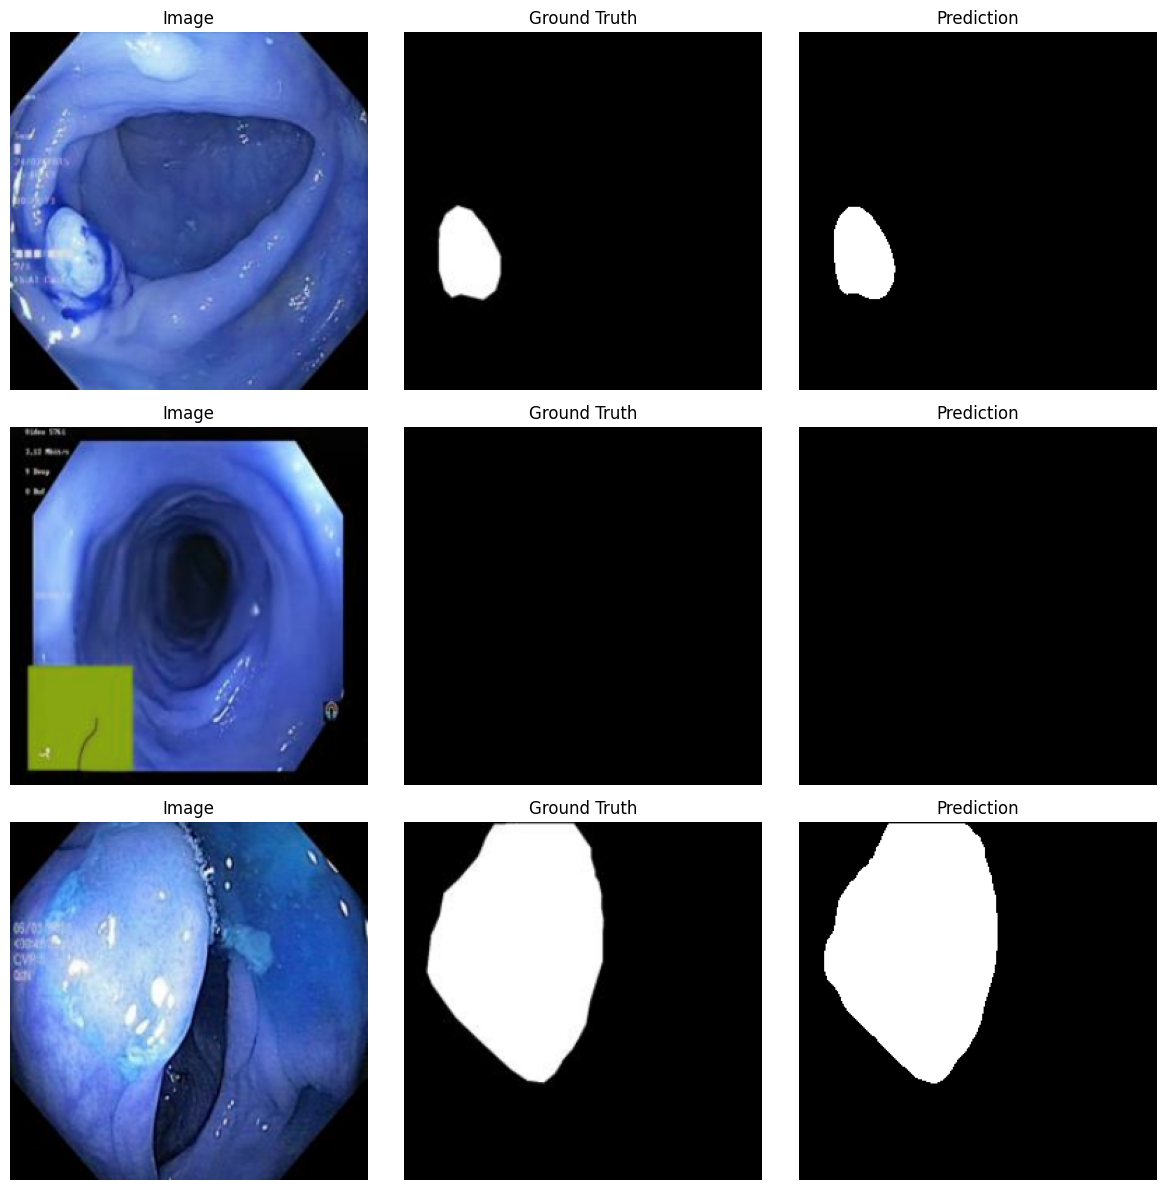

In [24]:
visualize_predictions(
    model_path="unet_model.pth",
    image_dir=r"D:\Biose\Train\Dataset\image",
    mask_dir=r"D:\Biose\Train\Dataset\label",
    num_samples=3
)


In [23]:
from sklearn.metrics import accuracy_score

def train_with_validation():
    # Paths
    image_dir = r"D:\Biose\Train\DatasetDump\image"
    mask_dir = r"D:\Biose\Train\DatasetDump\label"

    # Hyperparameters
    batch_size = 4
    lr = 1e-4
    epochs = 50
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Dataset & Split
    full_dataset = SegmentationDataset(image_dir, mask_dir)
    total_size = len(full_dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # Model
    model = UNet().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_preds = []
        train_targets = []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            preds = (outputs > 0.5).float()
            targets = (masks > 0.5).float()

            train_preds.extend(preds.cpu().numpy().flatten())
            train_targets.extend(targets.cpu().numpy().flatten())

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc = accuracy_score(train_targets, train_preds)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

                preds = (outputs > 0.5).float()
                targets = (masks > 0.5).float()

                val_preds.extend(preds.cpu().numpy().flatten())
                val_targets.extend(targets.cpu().numpy().flatten())

        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_acc = accuracy_score(val_targets, val_preds)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), "unet_model.pth")
    print("Model saved as unet_model.pth")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(val_accuracies, label="Val Accuracy", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50 | Train Loss: 0.4279 | Train Acc: 0.8445 | Val Loss: 0.3727 | Val Acc: 0.8525
Epoch 2/50 | Train Loss: 0.3687 | Train Acc: 0.8445 | Val Loss: 0.3655 | Val Acc: 0.8525
Epoch 3/50 | Train Loss: 0.3669 | Train Acc: 0.8445 | Val Loss: 0.3524 | Val Acc: 0.8525
Epoch 4/50 | Train Loss: 0.3661 | Train Acc: 0.8445 | Val Loss: 0.3715 | Val Acc: 0.8525
Epoch 5/50 | Train Loss: 0.3631 | Train Acc: 0.8445 | Val Loss: 0.3485 | Val Acc: 0.8525
Epoch 6/50 | Train Loss: 0.3559 | Train Acc: 0.8445 | Val Loss: 0.3461 | Val Acc: 0.8525
Epoch 7/50 | Train Loss: 0.3400 | Train Acc: 0.8484 | Val Loss: 0.3262 | Val Acc: 0.8556
Epoch 8/50 | Train Loss: 0.3367 | Train Acc: 0.8503 | Val Loss: 0.3268 | Val Acc: 0.8576
Epoch 9/50 | Train Loss: 0.3378 | Train Acc: 0.8532 | Val Loss: 0.3215 | Val Acc: 0.8536
Epoch 10/50 | Train Loss: 0.3308 | Train Acc: 0.8556 | Val Loss: 0.3199 | Val Acc: 0.8591
Epoch 11/50 | Train Loss: 0.3316 | Train Acc: 0.8548 | Val Loss: 0.3168 | Val Acc: 0.8588
Epoch 12/50 | Train

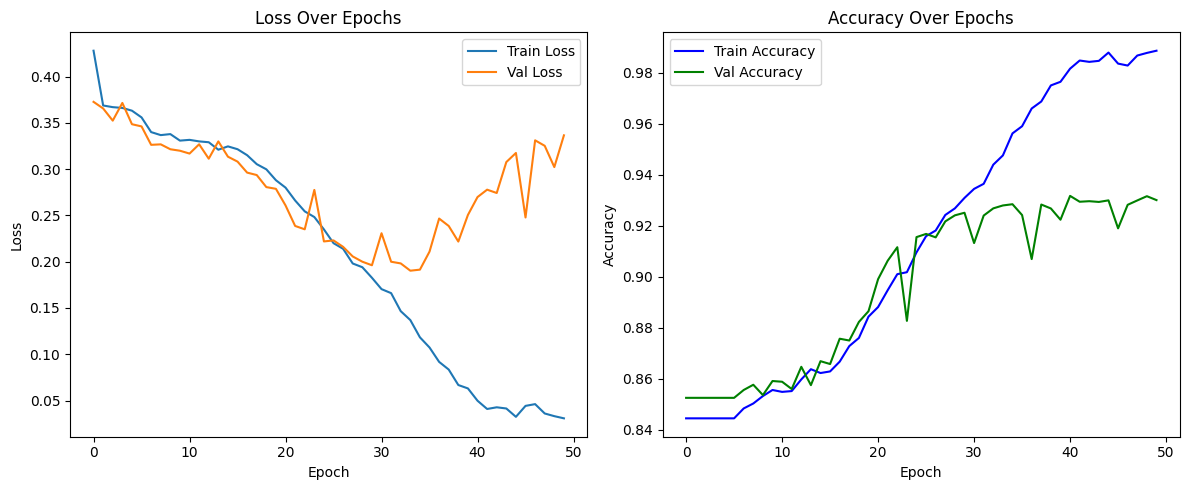

In [24]:
train_with_validation()
